# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

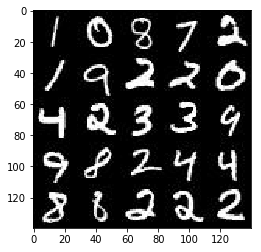

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

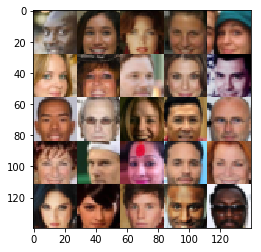

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0-rc1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_ph = tf.placeholder(tf.float32,shape=(None,image_width, image_height, image_channels), name="input")
    z_ph = tf.placeholder(tf.float32,shape=(None,z_dim),name="z_dim")
    lr_ph = tf.placeholder(tf.float32,name="learning_rate")
    return input_ph, z_ph, lr_ph


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.device('/device:GPU:0'):
        with tf.variable_scope('discriminator', reuse=reuse):
            
            # input 28*28*3
            x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
            x1 = tf.layers.dropout(x1, rate=0.3)
            relu1 = tf.maximum(0.2*x1, x1)
            
            # 14*14*64
            x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
            x2 = tf.layers.dropout(x2, rate=0.3)
            bn2 = tf.layers.batch_normalization(x2, training=True)
            relu2 = tf.maximum(0.2*bn2, bn2)
            
            # 7*7*128
            x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="same")
            x3 = tf.layers.dropout(x3, rate=0.3)
            bn3 = tf.layers.batch_normalization(x3, training=True)
            relu3 = tf.maximum(0.2*bn3, bn3)
            # 4*4*256

            flat = tf.reshape(relu3, (-1,4*4*256))

            logits = tf.layers.dense(flat,1)
            out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
 
    with tf.device('/device:GPU:1'):
        with tf.variable_scope('generator', reuse=(not is_train)):
            
            x1 = tf.layers.dense(z,7*7*256)
            x1 = tf.reshape(x1, (-1, 7, 7, 256))
            x1 = tf.layers.dropout(x1, rate=0.3)
            bn1 = tf.layers.batch_normalization(x1, training=is_train)
            relu1 = tf.maximum(0.2*bn1, bn1)
            # 7*7*256
            
            x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
            x2 = tf.layers.dropout(x2, rate=0.3)
            bn2 = tf.layers.batch_normalization(x2, training=is_train)
            relu2 = tf.maximum(0.2*bn2, bn2)
            
            #14*14*128
            
            x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
            x3 = tf.layers.dropout(x3, rate=0.3)
            bn3 = tf.layers.batch_normalization(x3, training=is_train)
            relu3 = tf.maximum(0.2*bn3, bn3)
            
            # 28*28*64
        

            logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 3, strides=1, padding='same')
            out = tf.tanh(logits)

    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen = generator(input_z, out_channel_dim, is_train=True)
    real, real_logits = discriminator(input_real)
    fake, fake_logits = discriminator(gen, reuse=True)
    
    real_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real)*0.9))
    fake_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake)))
    gen_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake)))
    
    disc_loss = real_loss + fake_loss
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainables = tf.trainable_variables()
    disc_vars = [x for x in trainables if x.name.startswith('discriminator')]
    gen_vars = [x for x in trainables if x.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    return disc_train, gen_train
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model


   
    ip_real, ip_z , lr = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    disc_loss, gen_loss = model_loss(ip_real, ip_z, data_shape[3])
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
             
                _ = sess.run([disc_opt,gen_opt], feed_dict={ip_real:batch_images, ip_z: batch_z, lr: learning_rate})
                
                steps += 1
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({ip_z: batch_z, ip_real: batch_images})
                    train_loss_g = gen_loss.eval({ip_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, ip_z, data_shape[3], data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8668... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 2.9418... Generator Loss: 0.1003
Epoch 1/2... Discriminator Loss: 1.8554... Generator Loss: 0.3222
Epoch 1/2... Discriminator Loss: 2.4585... Generator Loss: 0.1701
Epoch 1/2... Discriminator Loss: 2.1197... Generator Loss: 0.2445
Epoch 1/2... Discriminator Loss: 2.0089... Generator Loss: 0.2822
Epoch 1/2... Discriminator Loss: 1.8159... Generator Loss: 0.3742
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 2.4689... Generator Loss: 0.1437


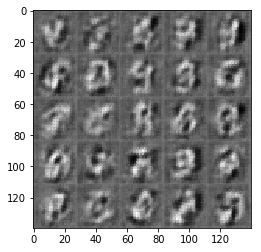

Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 2.1182
Epoch 1/2... Discriminator Loss: 1.8185... Generator Loss: 3.3096
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 2.7354
Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 1.8219
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 1.1819
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 1.5942
Epoch 1/2... Discriminator Loss: 1.5561... Generator Loss: 2.6828
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 1.0766
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 1.6701
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 1.4102


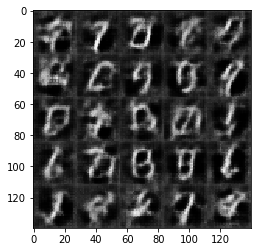

Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 3.8931
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 1.2445
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 1.2470
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 1.0055
Epoch 1/2... Discriminator Loss: 1.7257... Generator Loss: 3.0752
Epoch 1/2... Discriminator Loss: 1.7004... Generator Loss: 0.3470
Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.4817
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.8152
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.5325


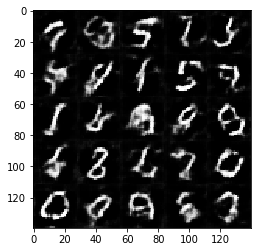

Epoch 1/2... Discriminator Loss: 1.6516... Generator Loss: 0.3876
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.5945
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.5064
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.5689
Epoch 1/2... Discriminator Loss: 2.0384... Generator Loss: 0.2453
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 1.2156
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 1.5278
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 2.9160
Epoch 1/2... Discriminator Loss: 1.7830... Generator Loss: 0.3325


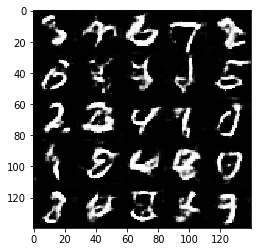

Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 1.9468... Generator Loss: 0.2757
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 1.5315... Generator Loss: 0.4706
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 1.6321
Epoch 1/2... Discriminator Loss: 1.7378... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 1.1063... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.2055
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.9810... Generator Loss: 3.6681


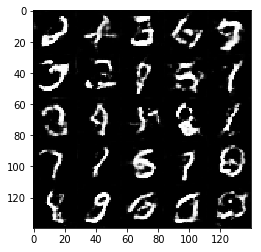

Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.6747
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 1.0048
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.7924
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 3.1788
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 1.5836
Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.5841
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 1.1105
Epoch 2/2... Discriminator Loss: 1.6598... Generator Loss: 3.1253
Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 0.9256


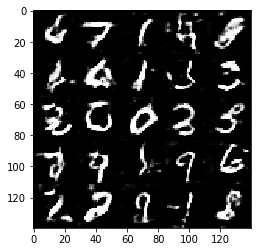

Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.5059
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 2.8066
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 1.0719
Epoch 2/2... Discriminator Loss: 2.4223... Generator Loss: 0.2135
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 1.4506... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.7484
Epoch 2/2... Discriminator Loss: 1.2674... Generator Loss: 0.6238


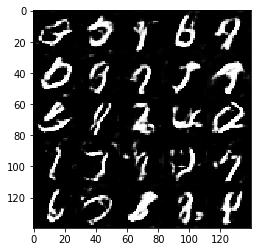

Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 2.3620
Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 1.7022
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 1.9426
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.5290
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 1.0349
Epoch 2/2... Discriminator Loss: 1.0531... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 0.8613... Generator Loss: 1.3246
Epoch 2/2... Discriminator Loss: 2.8907... Generator Loss: 4.7644


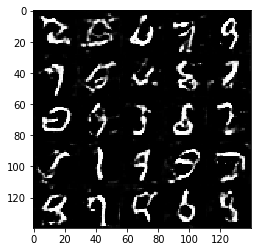

Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.2068
Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 1.8196
Epoch 2/2... Discriminator Loss: 1.3615... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 0.7350... Generator Loss: 1.6707
Epoch 2/2... Discriminator Loss: 0.8939... Generator Loss: 2.2476
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 1.3777
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.2589
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.2928
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 1.6888


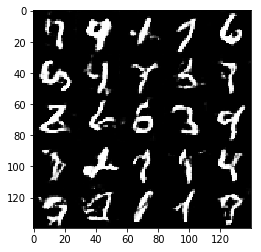

Epoch 2/2... Discriminator Loss: 3.1878... Generator Loss: 0.1297
Epoch 2/2... Discriminator Loss: 0.7068... Generator Loss: 1.5178
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 0.8313


In [27]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.8666... Generator Loss: 0.3321
Epoch 1/1... Discriminator Loss: 3.8599... Generator Loss: 7.9908
Epoch 1/1... Discriminator Loss: 3.6695... Generator Loss: 7.8303
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.5179
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.7209
Epoch 1/1... Discriminator Loss: 4.6992... Generator Loss: 0.0207
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 1.9701... Generator Loss: 0.2839


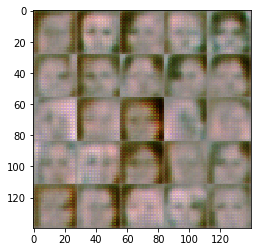

Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 1.8513... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 2.4636... Generator Loss: 2.7794
Epoch 1/1... Discriminator Loss: 3.7611... Generator Loss: 7.0017
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 1.9361
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.9052


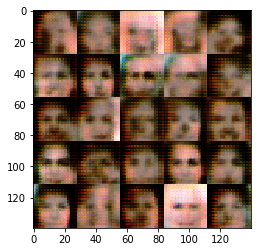

Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 1.8590
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.2388
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.8713
Epoch 1/1... Discriminator Loss: 2.5084... Generator Loss: 5.0654
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.5987


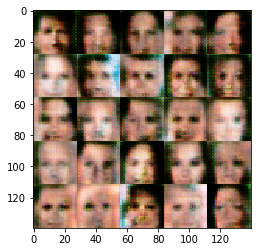

Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 1.5540
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.9663


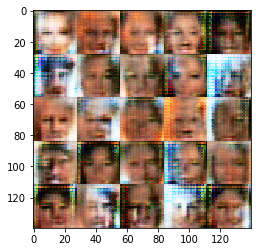

Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.5543


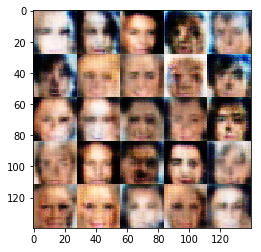

Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.9991
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 1.3962


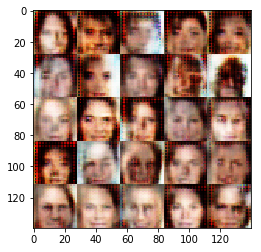

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.4131
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.3638
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.6823


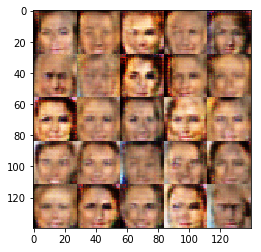

Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 1.3561
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.4183
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8254


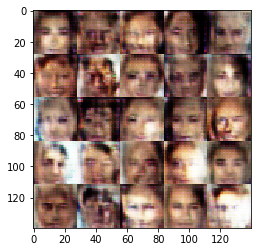

Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 1.2822
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.9782


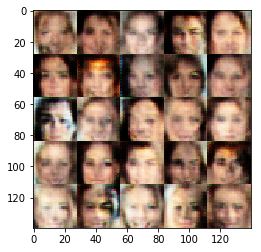

Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.7410
Epoch 1/1... Discriminator Loss: 1.7479... Generator Loss: 1.9141
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7449


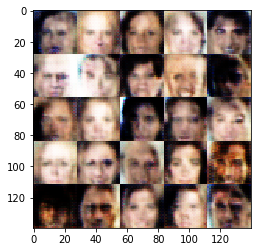

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 1.4808
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 2.1218
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 1.5834
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.9951


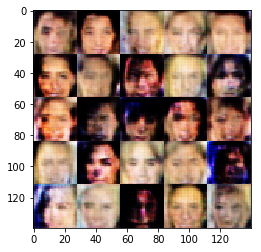

Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 1.1889


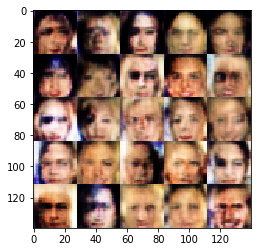

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 2.2275
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 2.0512
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5138


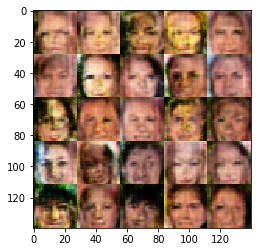

Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 1.4685
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.6193
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.8608


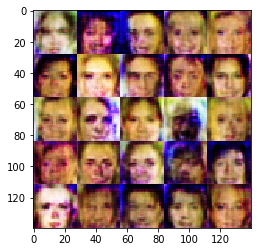

Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 2.6367
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.4516


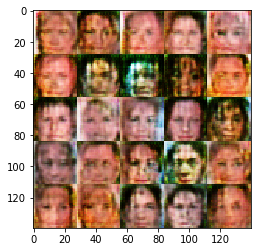

Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.7948... Generator Loss: 0.3259
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6334


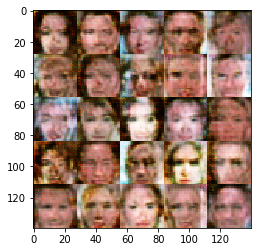

Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 1.5175
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 2.1409
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 3.0504... Generator Loss: 3.5800
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.6623


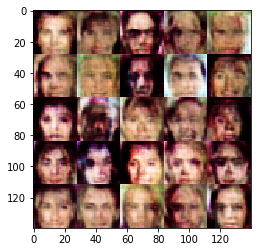

Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.7453
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.6260... Generator Loss: 2.8932
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.8825


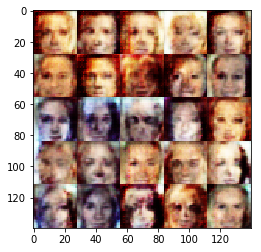

Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.8778
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 2.0590
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 2.3250
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.5682
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.3264


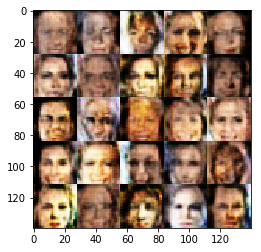

Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 2.0347
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 1.8933


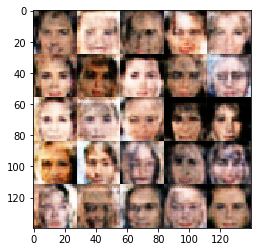

Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.5985
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 1.1881


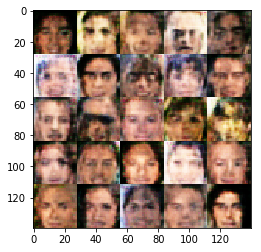

Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 2.7114
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.6878


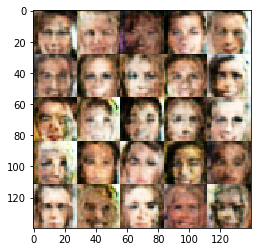

Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 1.0770
Epoch 1/1... Discriminator Loss: 2.0614... Generator Loss: 0.2200
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.0258


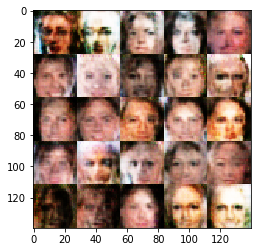

Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.6683... Generator Loss: 0.3760


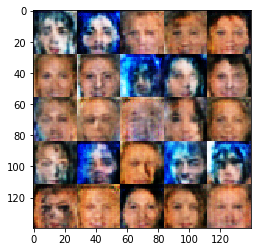

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 1.4376
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 0.9409


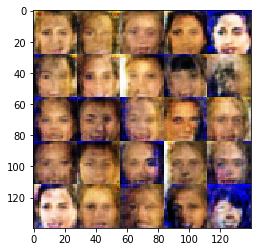

Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 2.4985
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.6509... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.0584


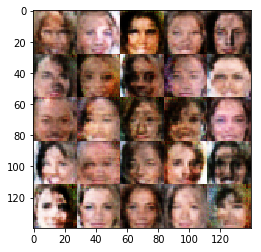

Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.8282... Generator Loss: 0.2954
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.9082... Generator Loss: 2.6585
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.1156


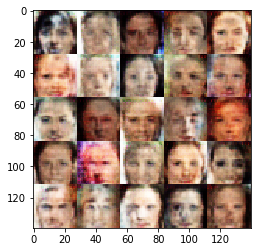

Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.0917


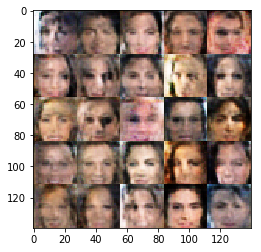

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.1685
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.8665


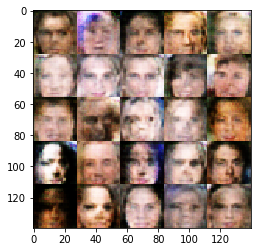

Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.5162
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 2.3801... Generator Loss: 0.1712
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 2.3300
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.7679
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.7343


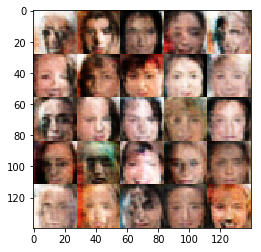

Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.1461


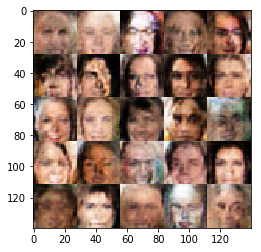

Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 2.5474
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.8901... Generator Loss: 2.9222


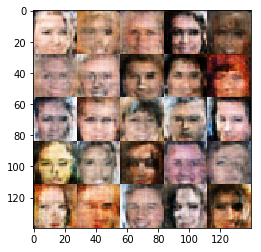

Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.5297


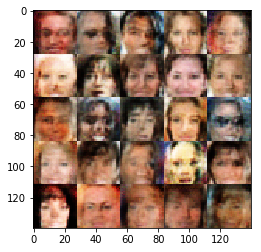

Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.7899
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.0116


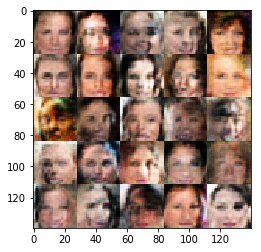

Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.5019
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.9674


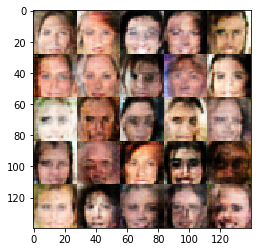

Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.3843
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.3150
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 2.9667
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.8586


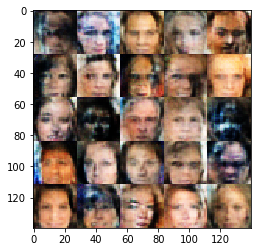

Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 2.1649... Generator Loss: 0.2089
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 2.4948
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.6367


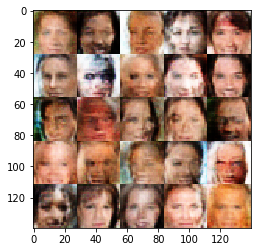

Epoch 1/1... Discriminator Loss: 1.7883... Generator Loss: 0.3097
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.4158
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.8257
Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.3727
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 1.5267
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6775


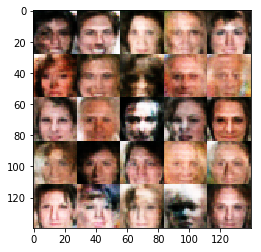

Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 2.3266
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.8591


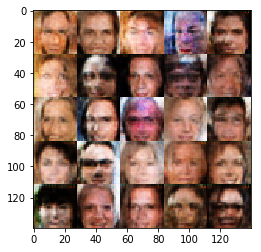

Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 2.3584
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.2903
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 2.0352
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.4829
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 2.1832


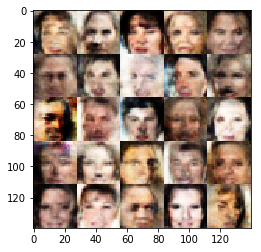

Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.7204... Generator Loss: 0.3376
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.9816
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.7161


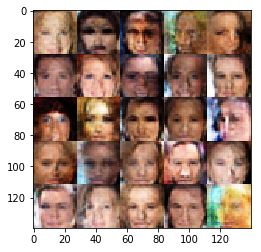

Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 1.7213... Generator Loss: 0.3119
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 1.7427... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.4891
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.4637


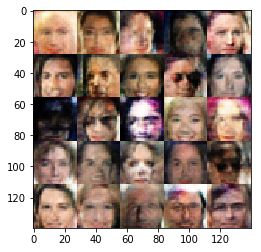

Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 2.2311... Generator Loss: 0.1922
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.9082
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.9250... Generator Loss: 0.2907


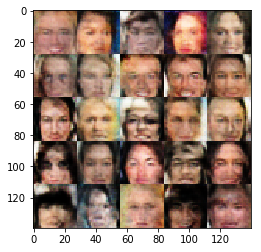

Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 2.1858
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.4636
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.8410
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.9373


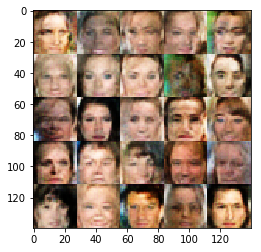

Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.4150
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.6738... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.4547
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 2.3170
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.9931
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.7142


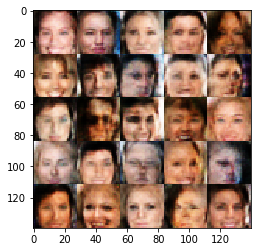

Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.7620... Generator Loss: 0.3248
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.4627
Epoch 1/1... Discriminator Loss: 1.8425... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 2.5307
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.8244... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.4822


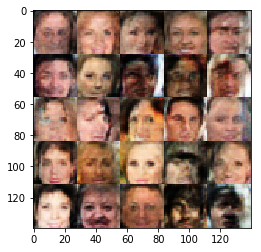

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.4254
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.7155
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 2.0599
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.7931
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7513


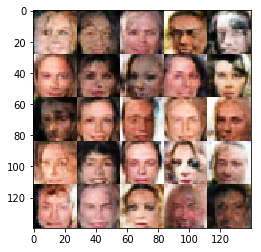

Epoch 1/1... Discriminator Loss: 1.8536... Generator Loss: 0.3049
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.4276
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 2.8647
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 1.7176
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.7890
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.6844


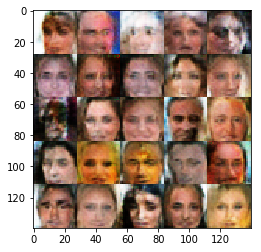

Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 2.5667
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 2.1358
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 2.0559... Generator Loss: 0.2707
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.7351


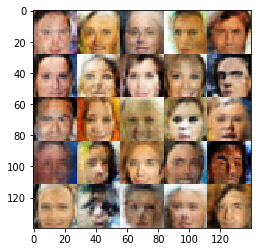

Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 2.5638
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 2.6472
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 2.3352
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.3876


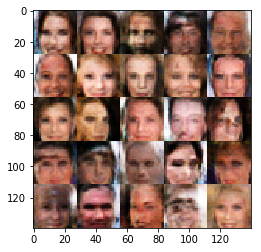

Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 2.3593
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 2.4502


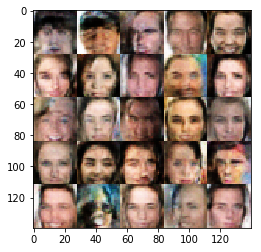

Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 3.0434
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.7034


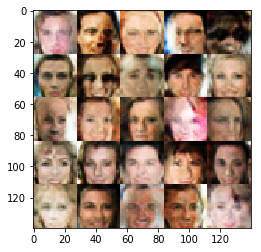

Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.5852
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.7078
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.9063


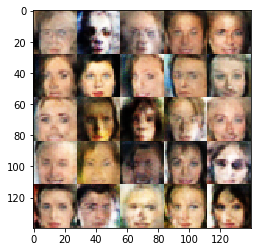

Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 2.2248
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 2.0451


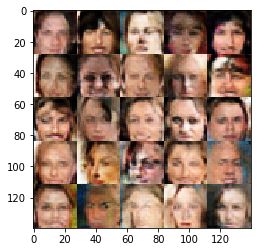

Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 2.0079
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.6246
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.6503


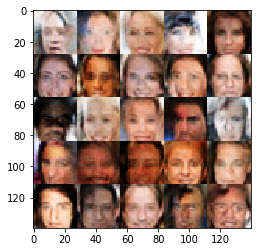

Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.4687
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 3.0095
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.7988
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.6875


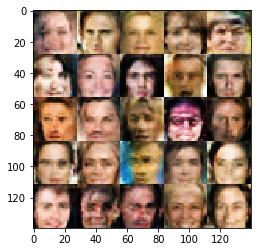

Epoch 1/1... Discriminator Loss: 1.9953... Generator Loss: 0.2473
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.9278
Epoch 1/1... Discriminator Loss: 1.9338... Generator Loss: 0.2830
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 2.1106
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.5218
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.9339


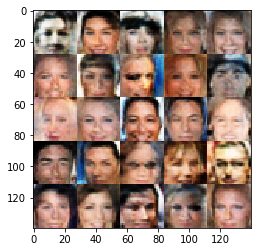

Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 2.0604
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.8343... Generator Loss: 0.3125
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 3.6973
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.8819
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 2.3433
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.4991


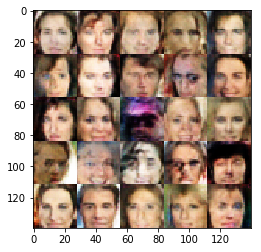

Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 3.4085
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.5034
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.8650
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5010


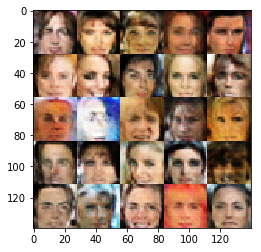

Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 1.6400... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.7487
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 2.1994
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.3926
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.9098... Generator Loss: 0.2898


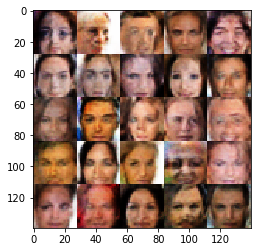

Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 2.1803
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.5545


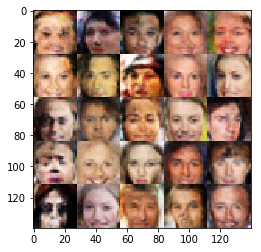

Epoch 1/1... Discriminator Loss: 1.8452... Generator Loss: 0.2867
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.6427... Generator Loss: 0.4604
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 2.6346


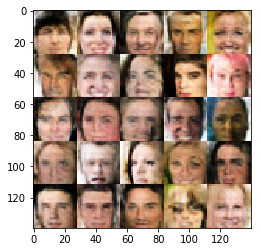

Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 3.0859
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 3.0616
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 1.6948... Generator Loss: 0.3545
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 2.1529


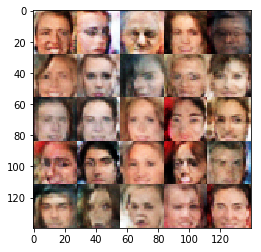

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.2311


In [28]:
batch_size = 32
z_dim = 64
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.